In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf1
from tensorflow.keras import activations
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-11-28 11:43:36.366382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from cust_rnn import BasicRNNCell

In [4]:
n_windows = 200
n_input =  1
n_output = 1
size_train = 2001
r_neuron = 120   

In [5]:
def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts
ts = create_ts(start = '2001', n = 2205)

In [6]:
series = np.array(ts[3:])
train = series[:size_train]
test = series[size_train:]
print(train.shape, test.shape)

(2001,) (201,)


In [7]:
x_data = train[:size_train-1]
X_batches = x_data.reshape(-1, n_windows, n_input)
def create_batches(df, windows, input, output):
    ## Create X         
        x_data = train[:size_train-1] # Select the data
        X_batches = x_data.reshape(-1, windows, input)  # Reshape the data 
    ## Create y
        y_data = train[n_output:size_train]
        y_batches = y_data.reshape(-1, windows, output)
        return X_batches, y_batches

In [8]:
X_batches, y_batches = create_batches(df = train,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)
print(X_batches.shape, y_batches.shape)

(10, 200, 1) (10, 200, 1)


In [9]:
X_test, y_test = create_batches(df = test, windows = 200,input = 1, output = 1)
print(X_test.shape, y_test.shape)

(10, 200, 1) (10, 200, 1)


In [10]:
params = {"l2scale":4e-6,
        "alpha_resample_ratio":0.9,
        "transition_std":[10,3,5],
        "time_step":1.0,
        "decayrate":0.5,
        "learningrate":0.0001,
        "num_particles":100,
        }

In [18]:
batch_num = 10
particle_states_inits = np.zeros((batch_num,params["num_particles"], 3)) 
for i in range(0,batch_num):
    ri = np.zeros((params["num_particles"], 3))
    # tsi = x_data[i*n_windows:i*n_windows + 3]
    # r = [tsi[2],  (tsi[2] - tsi[1]) / params['time_step'], ((tsi[2] - tsi[1]) - (tsi[1] - tsi[0])) / params['time_step']]

    #some cheating
    inc_data = x_data[i*n_windows:(i+1)*n_windows]
    v = [i-j for i,j in zip(inc_data[1:], inc_data[:-1])]
    a = [i-j for i,j in zip(v[1:], v[:-1])]
    r = [inc_data[0],  np.average(v), np.average(a)]
    for ridx in range(0,3):
        ri[:,ridx] = np.random.uniform(r[ridx] - params['transition_std'][ridx], r[ridx] + params['transition_std'][ridx], (params["num_particles"]))
    particle_states_inits[i] = ri


In [19]:
fv = np.log(1.0/float(params['num_particles']))
particle_weights_inits = np.full(shape=particle_states_inits.shape[:-1], fill_value=fv)

In [20]:
lag_len = 5
last_window_points = np.array([x_data[i-lag_len:i] if i>=lag_len else np.concatenate((np.zeros(lag_len-i),x_data[:i])) for i in range(0,len(x_data))]).reshape(batch_num, n_windows, -1)

In [21]:
from cust_rnn import PFNET

In [22]:
batches_to_include = 2
points_to_include = 5
fl = [X_batches[:batches_to_include,:points_to_include], particle_states_inits[:batches_to_include], particle_weights_inits[:batches_to_include], last_window_points[:batches_to_include,:points_to_include], y_batches[:batches_to_include, :points_to_include]]

In [23]:
[i.shape for i in fl]

[(2, 5, 1), (2, 100, 3), (2, 100), (2, 5, 5), (2, 5, 1)]

In [24]:
train_brain = PFNET(params, [fl[1].shape, fl[0].shape, fl[3].shape], fl[4].shape, True)

2022-11-28 11:44:50.649488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [25]:

init_op = tf.group(tf.compat.v1.global_variables_initializer(), tf.compat.v1.local_variables_initializer())
iteration = 20
with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    print("done with run init") #11
    # obs_in, init_particle_states, init_particle_weights, prev_window, true_pos
    
    fd = {i:fl[idx] for idx, i in enumerate(train_brain.inputs)}
    print("done with fd") #0
    for iters in range(iteration):
        _, loss, _, o= sess.run([train_brain.train_op, train_brain.train_loss_op,
                                               train_brain.update_state_op, train_brain.print_state_op], feed_dict=fd)
        print(loss)
    print("done with op") #4

2022-11-28 11:45:39.387219: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


done with run init
done with fd
402.3722
207.95154
1085.8752
130.1274
578.467
149.98221
163.10701
287.08496
839.83624
206.30344
177.69199
497.89972
193.99771
109.475174
676.71875
690.8661
572.6209
388.39874
668.778
276.80032
done with op


In [26]:
x_data[0]

-6.23948394830999

In [27]:
np.ptp(particle_states_inits[0][:,0]), np.mean(particle_states_inits[0][:,0])

(19.758979427861167, -6.331459450607332)

In [28]:
# iter_idx = 0
# test_states = o[0][0][iter_idx]
# test_weights = o[1][0][iter_idx]
# test_states.shape, test_weights.shape

In [29]:
iter_idx = 0
pre_trans_states = o[0][0][iter_idx]
post_trans_states = o[1][0]

In [30]:
x = np.array([0]*len(particle_states_inits[0]))

In [37]:
def cust_transition(p_states):
    pos_std = params['transition_std'][0] # position std
    vel_std = params['transition_std'][1]  # velocity std
    acc_std = params['transition_std'][2]  # acceleration std

    part_y = p_states[:,0]
    part_v = p_states[:,1]
    part_a = p_states[:,2]

    noise_y = np.random.normal(size = part_y.shape, loc=0.0, scale=1.0) * pos_std
    noise_v = np.random.normal(size = part_v.shape, loc=0.0, scale=1.0) * vel_std
    noise_a = np.random.normal(size = part_a.shape, loc=0.0, scale=1.0) * acc_std

    delta_y = part_y + (part_v * params['time_step']) + (0.5 * part_a * params['time_step']**2) + noise_y
    delta_v = part_v + (part_a * params['time_step']) + noise_v
    delta_a = part_a + noise_a

    new_p_states = np.zeros(p_states.shape)
    new_p_states[:,0] = delta_y
    new_p_states[:,1] = delta_v
    new_p_states[:,2] = delta_a
    return new_p_states

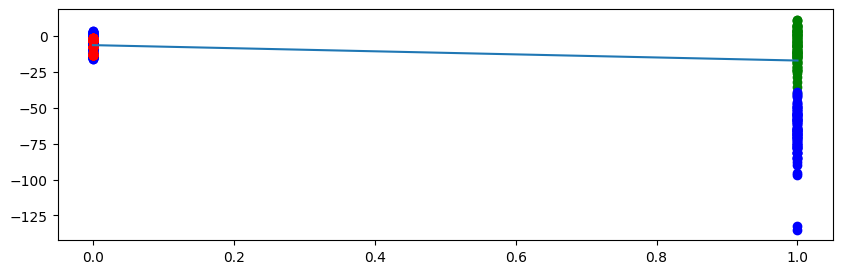

In [38]:
fig, ax = plt.subplots(1,1, figsize = (10,3))
ax.scatter(x,particle_states_inits[0,:,0], c = 'b')
ax.scatter(x,pre_trans_states[:,0], c = 'r')
ax.scatter(x+1,cust_transition(pre_trans_states)[:,0], c = 'g')
ax.scatter(x+1,post_trans_states[:,0], c = 'b')
ax.plot(x_data[:2])
# plt.plot([0]*len(pre_trans_states), pre_trans_states[:,0], c = 'r')
# plt.plot(x_data[:2])

In [ ]:
# test weights loved state sample 5, with value -8.568, velocity -14, acc -24
# i assume this sent all the weights into a massive downwards spiral

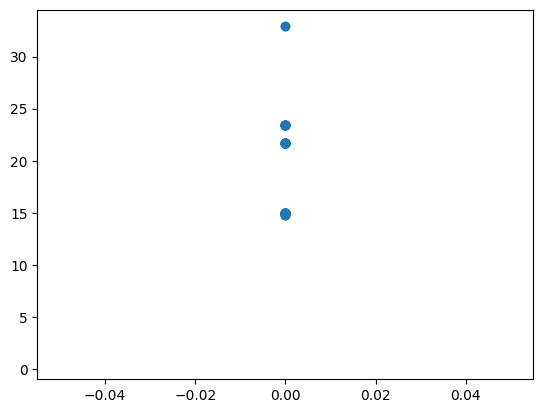

In [ ]:
points_to_plot = points_to_include
states_over_time = o[0][0][:,:,0]
plt.plot(X_batches[0][:points_to_plot])
for idx, s in enumerate(states_over_time[:points_to_plot]):
    plt.scatter([idx] * len(s), s)

In [ ]:
X = tf.keras.Input(dtype = tf.float32, shape = (n_windows, n_input), batch_size=10)
y = tf.keras.Input(dtype = tf.float32, shape = (n_windows, n_output), batch_size=10)
# X = tf.placeholder(tf.float32, [None, n_windows, n_input])   
# y = tf.placeholder(tf.float32, [None, n_windows, n_output])

basic_cell = BasicRNNCell(r_neuron, activation=tf.nn.relu) 
# basic_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(r_neuron, activation=tf.nn.relu) 

# rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)              
rnn_output, states = tf.keras.layers.RNN(cell = basic_cell, dtype = tf.float32, return_sequences=True, return_state=True)(inputs = X)
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.keras.layers.Dense(n_output)(stacked_rnn_output)
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])

build called
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-11-28 11:19:11.384258: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_2/bias/Assign' id:755 op device:{requested: '', assigned: ''} def:{{{node dense_2/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_2/bias, dense_2/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [ ]:
learning_rate = 0.001  
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss) 

In [ ]:
init = tf.compat.v1.global_variables_initializer() 
iteration = 1500 

with tf.compat.v1.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 222302510.0
150 	MSE: 772299.6
300 	MSE: 267358.25
450 	MSE: 201844.81
600 	MSE: 196965.84
750 	MSE: 190692.28
900 	MSE: 190669.06
1050 	MSE: 199404.62
1200 	MSE: 182394.16
1350 	MSE: 178889.53


/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_45329/2606641324.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_45329/2606641324.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')


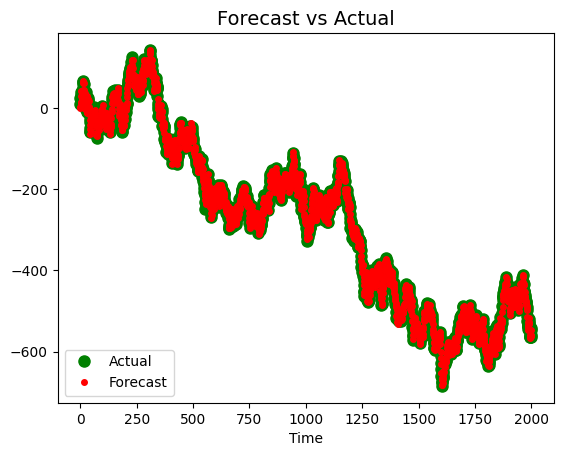

In [ ]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

plt.show()